In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from catboost import Pool

import featuretools as ft
from featuretools import selection

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, mutual_info_classif


from category_encoders import OrdinalEncoder, OneHotEncoder
from category_encoders import BackwardDifferenceEncoder, HelmertEncoder, BinaryEncoder
from category_encoders import CountEncoder
from category_encoders import LeaveOneOutEncoder, TargetEncoder, JamesSteinEncoder, MEstimateEncoder, WOEEncoder, CatBoostEncoder
from category_encoders.wrapper import NestedCVWrapper

from catboost import CatBoostRegressor

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/featuretools/__init__.py:60: FutureWarning:

The next non-bugfix release of Featuretools will not support Python 3.6



In [2]:
sample_subm = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

<AxesSubplot:>

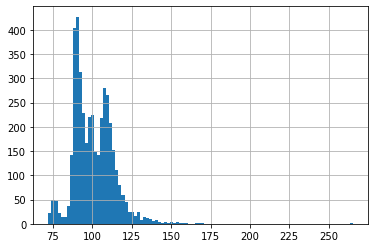

In [103]:
train.y.hist(bins=100)

# Возможно стоит логарифмировать таргет

In [4]:
X_train, y_train = train.drop('y',1), train.y 
X_test = test

In [5]:
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train, y_train)

In [6]:
model = CatBoostRegressor(max_depth=8,
                         thread_count=60,
                         n_estimators=300,
                         verbose=False, 
                        early_stopping_rounds=5)

In [7]:
# Regression model
model_le = Pipeline([
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('constant_remover', VarianceThreshold(0.0)),
    ('regressor', model)
])

# Cross-validated R2
r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=5, scoring=r2_scorer)
print('Cross-validated R2: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated R2: 0.458 +/- 0.129


# На случай если понадобится кастомная метрика

In [8]:
# my_scorer = make_scorer(adjusted_rsquare, greater_is_better=True)
# def adjusted_rsquare(y_true, y_pred, **kwargs):

# Теперь добавим генерацию фичей

In [9]:
# Merge application data
train['Test'] = False
test['Test'] = True
test['TARGET'] = np.nan
train.rename(columns={'y':'TARGET'}, inplace=True)
app = train.append(test, ignore_index=True, sort=False).drop('ID',1).reset_index()

In [10]:
# Create an entity set
es = ft.EntitySet(id='mercedes')

In [11]:
# Add dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='mercedes',
    dataframe=app,
    index='index'
)

In [12]:
# Manually define datatypes in app dataframe
variable_types = {
    'X0': ft.variable_types.Categorical
}

# Add dataframe to entityset, using manual datatypes
es = es.entity_from_dataframe(
    entity_id='mercedes',
    dataframe=app,
    index='index',
    variable_types=variable_types
)

In [13]:
agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['cum_sum']
dfs_feat, dfs_defs = ft.dfs(
    entityset=es,
    target_entity='mercedes',
    trans_primitives=trans_primitives,
    agg_primitives=agg_primitives, 
    max_features=1000,
    chunk_size=2000,
    verbose=True,                            
    max_depth=2,
    n_jobs=-1
)

Built 747 features
Fewer chunks (5), than workers (64) consider reducing the chunk size
EntitySet scattered to 64 workers in 11 seconds
Elapsed: 00:02 | Progress: 100%|██████████


In [14]:
dfs_feat

,TARGET,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,CUM_SUM(X90),CUM_SUM(X91),CUM_SUM(X92),CUM_SUM(X93),CUM_SUM(X94),CUM_SUM(X95),CUM_SUM(X96),CUM_SUM(X97),CUM_SUM(X98),CUM_SUM(X99)
index,,,,,,,,,,,,,,,,,,,,,
0,130.81,v,at,a,d,u,j,o,0,0,...,0,0,0,0,0,0,0,0,0,0
1,88.53,t,av,e,d,y,l,o,0,0,...,0,0,0,0,0,0,1,0,1,0
2,76.26,w,n,c,d,x,j,x,0,0,...,0,0,0,0,0,0,2,0,2,0
3,80.62,t,n,f,d,x,l,e,0,0,...,0,0,0,0,0,0,3,0,3,0
4,78.02,v,n,f,d,h,d,n,0,0,...,0,0,0,0,0,0,4,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8413,NaN,h,as,f,d,aa,j,e,0,0,...,66,18,14,2,64,4,6335,24,7931,78
8414,NaN,aa,ai,d,d,aa,j,y,0,0,...,66,18,14,2,64,4,6336,24,7932,78
8415,NaN,v,as,f,d,aa,d,w,0,0,...,66,18,14,2,64,4,6337,24,7933,78


In [15]:
filtered = selection.remove_low_information_features(dfs_feat)

In [16]:
# Split data back into test + train
train = dfs_feat.loc[~app['Test'].values, :].copy()
test = dfs_feat.loc[app['Test'].values, :].copy()

test.drop('TARGET',1,inplace=True)

In [17]:
X_train, y_train = train.drop('TARGET',1), train.TARGET 
X_test = test

In [18]:
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train, y_train)

In [19]:
model_le = Pipeline([
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('constant_remover', VarianceThreshold(0.0)),
    ('regressor', model)
])

# Cross-validated R2
r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=5, scoring=r2_scorer)
print('Cross-validated R2: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated R2: 0.416 +/- 0.142


# На это датасете результат ухудшился

# Shap

In [20]:
sample_subm = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [21]:
# Добавление шумовой фичи
train['noise'] = np.random.normal(size=train.shape[0])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('y',1), train.y, test_size=0.25, random_state=42)

In [23]:
X_train = X_train[['X0','X118','X5','X127','noise']]
X_test = X_test[['X0','X118','X5','X127','noise']]

In [24]:
y_train = np.log(y_train)
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train, y_train)

In [25]:
model = CatBoostRegressor(max_depth=8,
                         thread_count=60,
                         n_estimators=300,
                         verbose=False, 
                        early_stopping_rounds=5)

In [26]:
model.fit(X_target_encoded, y_train)

In [27]:
X_test = te.transform(X_test[['X0','X118','X5','X127','noise']])

In [28]:
import shap

y_predict = model.predict(X_test)
explainer = shap.TreeExplainer(model)
y_predict = pd.Series(y_predict.reshape(-1))
shap_values = explainer(X_test)
# shap_values = shap_values.values[:,:,0]
expl_dataset = pd.DataFrame(shap_values.values, columns = X_test.columns)
expl_dataset = expl_dataset[[c for c
        in list(expl_dataset)
        if len(expl_dataset[c].unique()) > 1]]

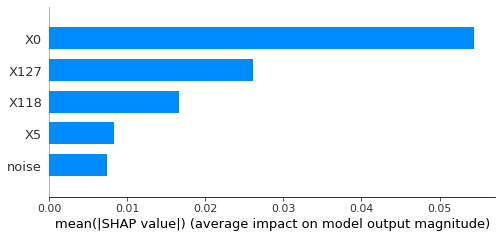

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [30]:
vals  = np.abs(shap_values.values).mean(0)
feature_names = X_train.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                               columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by='feature_importance_vals', ascending=False, inplace=True)
feature_importance

,col_name,feature_importance_vals
0,X0,0.054442
3,X127,0.026102
1,X118,0.016685
2,X5,0.008367
4,noise,0.007410


# Возьмем для обучения только те признаки, значимость которых выше шума

In [31]:
sample_subm = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [32]:
X_train, y_train = train.drop('y',1), train.y 
X_test = test

In [33]:
# y_train = np.log(y_train)

In [34]:
X_train = X_train[['X0','X118','X5','X127']]
X_test = X_test[['X0','X118','X5','X127']]

In [35]:
# Regression model
model_le = Pipeline([
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('constant_remover', VarianceThreshold(0.0)),
    ('regressor', model)
])

# Cross-validated R2
r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=5, scoring=r2_scorer)
print('Cross-validated R2: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated R2: 0.522 +/- 0.057


# Optuna

In [36]:
X_train = X_train[['X0','X118','X5','X127']]
X_test = X_test[['X0','X118','X5','X127']]

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
%%time
def objective(trial):
    
    import warnings
    warnings.filterwarnings('ignore')
    
    # Parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 100, 2000),                         
        'depth' : trial.suggest_int('depth', 6, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 0, 100),
    }
    
    model = CatBoostRegressor(
                         thread_count=60,
                         verbose=False, 
                        early_stopping_rounds=7,
                        eval_metric="R2",
                        **params)
    
    model_cross = Pipeline([
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('constant_remover', VarianceThreshold(0.0)),
    ('regressor', model)
])

    # Cross-validated R2
    r2_scorer = make_scorer(r2_score)
    mse_scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model_cross, X_train, y_train, 
                             cv=5, scoring=r2_scorer)    
    return scores.mean()

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16.5 µs


In [39]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_jobs = 64, n_trials=100)

[I 2021-09-22 15:09:11,437] A new study created in memory with name: no-name-5b3fc0e4-cd2e-4b28-a60b-35679677b248
[I 2021-09-22 15:09:56,991] Trial 10 finished with value: 0.5626481908636675 and parameters: {'iterations': 205, 'depth': 6, 'learning_rate': 0.03097513947310748, 'random_strength': 35, 'bagging_temperature': 0.012755806075948672, 'od_type': 'IncToDec', 'l2_leaf_reg': 14}. Best is trial 10 with value: 0.5626481908636675.
[I 2021-09-22 15:10:02,219] Trial 7 finished with value: 0.47690161069594217 and parameters: {'iterations': 303, 'depth': 7, 'learning_rate': 0.07483140143301954, 'random_strength': 14, 'bagging_temperature': 0.05062932749715424, 'od_type': 'Iter', 'l2_leaf_reg': 0}. Best is trial 10 with value: 0.5626481908636675.
[I 2021-09-22 15:10:02,930] Trial 30 finished with value: 0.5637497369081615 and parameters: {'iterations': 376, 'depth': 7, 'learning_rate': 0.025191402093630556, 'random_strength': 94, 'bagging_temperature': 0.3129719646744834, 'od_type': 'Iter

In [40]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.5646229314598946
  Params: 
    iterations: 964
    depth: 9
    learning_rate: 0.012608315388862645
    random_strength: 71
    bagging_temperature: 1.2178081224877062
    od_type: Iter
    l2_leaf_reg: 40


In [41]:
sample_subm = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [42]:
X_train, y_train = train.drop('y',1), train.y 
X_test = test
X_train = X_train[['X0','X118','X5','X127']]
X_test = X_test[['X0','X118','X5','X127']]

In [43]:
model = CatBoostRegressor(
                     thread_count=64,
                     verbose=False, 
                    early_stopping_rounds=7,
                    eval_metric="R2",
                    **trial.params)

In [44]:
# Regression model
model_le = Pipeline([
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('constant_remover', VarianceThreshold(0.0)),
    ('regressor', model)
])

# Cross-validated R2
r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=5, scoring=r2_scorer)
print('Cross-validated R2: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated R2: 0.565 +/- 0.068


In [45]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('y',1), train.y, test_size=0.25, random_state=42)

In [46]:
model = CatBoostRegressor(
                     thread_count=64,
                     verbose=False, 
                    early_stopping_rounds=7,
                    eval_metric="R2",
                    **trial.params)
model_le = Pipeline([
    ('encoder', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('constant_remover', VarianceThreshold(0.0)),
    ('regressor', model)
])

In [47]:
model_le.fit(X_train, y_train)
r2_score(y_test, model_le.predict(X_test))

0.5486756619732596

In [102]:
sample_subm['y'] = model_le.predict(test)
sample_subm.to_csv('submission.csv', header=True, index=False)

# Теперь сравним с различными auto-ml

## Auto Gluon

In [ ]:
pip install autogluon

In [49]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [50]:
sample_subm = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('y',1), train.y, test_size=0.25, random_state=42)

In [52]:
train = pd.concat([X_train,y_train],1)
test = pd.concat([X_test,y_test],1)

In [53]:
label='y'
save_path = 'agModels-predictClass'  # specifies folder to store trained models
predictor = TabularPredictor(label=label, path=save_path).fit(train)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    3156
Train Data Columns: 377
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (265.32, 72.11, 100.6526, 12.70342)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    326375.97 MB
	Train Data (Original)  Memory Usage: 10.79 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...

In [54]:
test_data = TabularDataset(test)
y_test = test_data[label]  # values to predict
test_data_nolab = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
1073,2140,al,o,ai,f,d,ag,j,l,0,...,0,0,0,0,0,0,0,0,0,0
144,310,f,l,ae,f,d,i,i,w,0,...,0,0,0,0,0,0,0,0,0,0
2380,4779,j,aa,ay,c,d,n,l,o,1,...,1,0,0,0,0,0,0,0,0,0
184,385,az,y,b,c,d,i,j,l,0,...,0,0,0,0,0,0,1,0,0,0
2587,5180,ak,v,ak,d,d,m,i,r,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -8.301546458468565
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -8.301546458468565,
    "mean_squared_error": -68.91567360211198,
    "mean_absolute_error": -5.444510276337974,
    "r2": 0.5663920985694542,
    "pearsonr": 0.7534198660471509,
    "median_absolute_error": -4.063115539550779
}


Predictions:  
 1073     96.928436
144      94.046646
2380    113.834068
184      78.987099
2587    112.156639
           ...    
283     113.100273
2770     94.847260
2833     80.319862
3762    111.313873
1482     94.026985
Name: y, Length: 1053, dtype: float32


In [56]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-8.301546,-7.928366,0.259077,0.163597,12.537557,0.004291,0.000589,0.335555,2,True,11
1,LightGBMXT,-8.319876,-7.985736,0.014936,0.013797,1.082615,0.014936,0.013797,1.082615,1,True,3
2,CatBoost,-8.322216,-7.955904,0.034373,0.033250,2.608936,0.034373,0.033250,2.608936,1,True,6
3,LightGBM,-8.376015,-8.050874,0.021884,0.015081,0.930354,0.021884,0.015081,0.930354,1,True,4
4,XGBoost,-8.525472,-8.249303,0.048604,0.015841,0.588511,0.048604,0.015841,0.588511,1,True,9
5,LightGBMLarge,-8.716823,-8.293589,0.017964,0.023913,5.302951,0.017964,0.023913,5.302951,1,True,10
6,RandomForestMSE,-9.139125,-8.697600,0.287047,0.229697,1.266510,0.287047,0.229697,1.266510,1,True,5
7,NeuralNetFastAI,-9.289003,-8.619927,0.183593,0.100879,7.580097,0.183593,0.100879,7.580097,1,True,8
8,ExtraTreesMSE,-9.428478,-8.738627,0.295062,0.128915,1.044439,0.295062,0.128915,1.044439,1,True,7
9,KNeighborsUnif,-14.093174,-13.670363,0.121902,0.118264,0.018686,0.121902,0.118264,0.018686,1,True,1


In [57]:
r2_score(y_test, y_pred)

0.5663920985694542

In [90]:
sample_subm

,ID,y
0,1,100.669318
1,2,100.669318
2,3,100.669318
3,4,100.669318
4,5,100.669318
...,...,...
4204,8410,100.669318
4205,8411,100.669318
4206,8413,100.669318
4207,8414,100.669318


In [96]:
sample_subm.y

0        79.477486
1        93.956505
2        79.333595
3        79.343613
4       111.856514
           ...    
4204    103.179222
4205     93.212814
4206     92.642021
4207    110.236572
4208     92.631271
Name: y, Length: 4209, dtype: float32

## H2O

In [ ]:
pip install h2o

In [ ]:
import h2o
h2o.init()

In [61]:
# получил ошибку

In [ ]:
from h2o.automl import H2OAutoML
# Identify predictors and response
x = [c for c in train.columns if c not in ('default.payment.next.month', 'ID')]
y = 'default.payment.next.month'

# For binary classification, response should be a factor
train[y] = train[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

## LAMA

In [ ]:
pip install lightautoml

In [64]:
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
import torch
import os

In [65]:
N_THREADS = 64
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.25
TIMEOUT = 300
TARGET_NAME = 'y'

In [66]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [67]:
%%time

data = pd.read_csv('train.csv')
data.head()

CPU times: user 111 ms, sys: 29.9 ms, total: 141 ms
Wall time: 139 ms


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [68]:
%%time

tr_data, te_data = train_test_split(data, 
                                    test_size=TEST_SIZE, 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (3156, 378), te_data = (1053, 378)
CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 9.97 ms


In [69]:
%%time

task = Task('reg', )

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.67 ms


In [70]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['ID']
         }

CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 26.7 µs


In [71]:
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       memory_limit = 64,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb'], ['linear_l2', 'lgb_tuned']]},
                       tuning_params={'max_tuning_iter': 5},
                      )

In [81]:
sample_subm = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [82]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('y',1), train.y, test_size=0.25, random_state=42)

In [83]:
automl.fit_predict(pd.concat([X_train, y_train],1), roles = roles)

Start automl preset with listed constraints:
- time: 300 seconds
- cpus: 64 cores
- memory: 64 gb

Train data shape: (3156, 378)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 260.797598361969 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -108.3737847547125
Linear model: C = 5e-05 score = -88.36382548178936
Linear model: C = 0.0001 score = -84.54969601065066
Linear model: C = 0.0005 score = -82.7007256122448
Linear model: C = 0.001 score = -83.09104426686677
Linear model: C = 0.005 score = -84.66454956785506

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -97.45912277044373
Linear model: C = 5e-05 score = -72.40877662423227
Linear model: C = 0.0001 score = -66.8131024621608
Linear model: C = 0.0005 score = -63.19683079678621
Linear model: C = 0.001 score = -63.53496370606508

A new study created in memory with name: no-name-f5926949-e656-4d29-bf21-a05657d6b527


Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 89.4943
[200]	valid's l2: 80.316
[300]	valid's l2: 79.0699
[400]	valid's l2: 78.3816
[500]	valid's l2: 78.3385
[600]	valid's l2: 78.424
Early stopping, best iteration is:
[411]	valid's l2: 78.3347
Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


Trial 0 finished with value: -78.3346880751718 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -78.3346880751718.


Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 88.9834
[200]	valid's l2: 80.0609
[300]	valid's l2: 78.8782
[400]	valid's l2: 78.1862
[500]	valid's l2: 77.8201
[600]	valid's l2: 77.8824
[700]	valid's l2: 77.8647
Early stopping, best iteration is:
[546]	valid's l2: 77.7502
Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


Trial 1 finished with value: -77.75017399810498 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 1 with value: -77.75017399810498.


Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 89.9002
[200]	valid's l2: 80.6277
[300]	valid's l2: 79.4208
[400]	valid's l2: 78.7183
[500]	valid's l2: 78.6488
[600]	valid's l2: 78.6542
[700]	valid's l2: 78.677
Early stopping, best iteration is:
[579]	valid's l2: 78.5691
Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


Trial 2 finished with value: -78.56914597801108 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}. Best is trial 1 with value: -77.75017399810498.


Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 89.9842
[200]	valid's l2: 80.4714
[300]	valid's l2: 79.1655
[400]	valid's l2: 78.4301
[500]	valid's l2: 78.3184
[600]	valid's l2: 78.2642
[700]	valid's l2: 78.2751
Early stopping, best iteration is:
[581]	valid's l2: 78.1907
Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


Trial 3 finished with value: -78.19067816960373 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223}. Best is trial 1 with value: -77.75017399810498.


Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 88.7578
[200]	valid's l2: 79.5884
[300]	valid's l2: 78.5355
[400]	valid's l2: 77.8624
[500]	valid's l2: 77.5664
[600]	valid's l2: 77.6918
[700]	valid's l2: 77.9082
Early stopping, best iteration is:
[528]	valid's l2: 77.5225
Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


Trial 4 finished with value: -77.52250128613453 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185}. Best is trial 4 with value: -77.52250128613453.


Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 78.9078
[200]	valid's l2: 78.7634
Early stopping, best iteration is:
[165]	valid's l2: 78.3359

===== Start working with fold 1 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 57.599
Early stopping, best iteration is:
[88]	valid's l2: 57.323

===== Start working with fold 2 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 103.204
Early stopping, best iteration is:
[90]	valid's l2: 102.944

===== Start working with fold 3 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 53.5342
Early stopping, best iteration is:
[56]	valid's l2: 51.8913

===== Start working with fold 4 for Lvl_1_Pipe_1

array([[117.86851 ],
       [ 96.76283 ],
       [ 96.45785 ],
       ...,
       [ 92.007996],
       [ 94.88602 ],
       [ 95.24202 ]], dtype=float32)

In [84]:
preds = automl.predict(X_test)

In [85]:
r2_score(y_test, preds.data)

0.5507655491033524

# Итог:
1. Auto Gluon (0.566)
2. CatBoost + Optuna + tricks (0.565)
3. LAMA (0.551)